# Inference on pretrained HRNet-OCR model

In this code, we perform Semantic segmentation on Critical Electrical Infrastructure (Pole)
* Inference with MMSeg trained weight (HRNet-OCR)
* Save predictions
* Evaluate using IOU metric

## Install MMSegmentation
This step may take several minutes. 

We use PyTorch 1.10 and CUDA 11.1 for this tutorial. You may install other versions by change the version number in pip install command. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
# Install PyTorch
!pip install torch==1.12.0 torchvision --extra-index-url https://download.pytorch.org/whl/cu113
# Install MMCV
!pip install openmim
!mim install mmcv-full==1.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     |██████████████▌                 | 834.1 MB 1.2 MB/s eta 0:14:19tcmalloc: large alloc 1147494400 bytes == 0x38c84000 @  0x7fc41be73615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |██████████████████▍             | 1055.7 MB 93.5 MB/s eta 0:00:09tcmalloc: large alloc 1434370048 bytes == 0x7d2da000 @  0x7fc41be73615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |███████████████████████▎        |

In [4]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 12947, done.
remote: Total 12947 (delta 0), reused 0 (delta 0), pack-reused 12947
Receiving objects: 100% (12947/12947), 15.13 MiB | 16.69 MiB/s, done.
Resolving deltas: 100% (9359/9359), done.
/content/mmsegmentation
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/mmsegmentation
     |████████████████████████████████| 648 kB 36.7 MB/s 
  Running setup.py develop for mmsegmentation


In [5]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.12.0+cu113 True
0.29.1


## Upload data from drive

In [6]:
!mkdir checkpoints

from google.colab import drive
import os
from os import path
import shutil

drive.mount('/content/drive')

### Change the directories to reflect where your data is located !!!
%cp -av "/content/drive/MyDrive/NRCan2022/data_NRCan2022_hrnet"  "/content/mmsegmentation/data_NRCan2022_hrnet"

# Download pretrained weights from HRNet-OCR implemented on Cityscapes dataset
%cp -av "/content/drive/MyDrive/NRCan2022/model_checkpoint_finetuned_poles_hrnet"  "/content/mmsegmentation/checkpoints"

# Update the class_names.py file to get a palette with two colours (poles-yellow, background-purple)
%rm "/content/mmsegmentation/mmseg/core/evaluation/class_names.py"
%cp -av "/content/drive/MyDrive/NRCan2022/class_names_finetuned.py"  "/content/mmsegmentation/mmseg/core/evaluation/class_names.py"

# Update the inference.py file to get class and palette arguments for model initialization
%rm "/content/mmsegmentation/mmseg/apis/inference.py"
%cp -av "/content/drive/MyDrive/NRCan2022/inference.py"  "/content/mmsegmentation/mmseg/apis/inference.py"

Streaming output truncated to the last 5000 lines.
'/content/drive/MyDrive/NRCan2022/data_NRCan2022_hrnet/poles/yasmina_data/ann_dir/train/img_ref_0_stp_1_lat_45.3582851136_lon_-76.2895280133_hdg_587.213684082.png' -> '/content/mmsegmentation/data_NRCan2022_hrnet/poles/yasmina_data/ann_dir/train/img_ref_0_stp_1_lat_45.3582851136_lon_-76.2895280133_hdg_587.213684082.png'
'/content/drive/MyDrive/NRCan2022/data_NRCan2022_hrnet/poles/yasmina_data/ann_dir/train/img_ref_0_stp_1_lat_45.3015282706_lon_-75.2349071411_hdg_337.461791992.png' -> '/content/mmsegmentation/data_NRCan2022_hrnet/poles/yasmina_data/ann_dir/train/img_ref_0_stp_1_lat_45.3015282706_lon_-75.2349071411_hdg_337.461791992.png'
'/content/drive/MyDrive/NRCan2022/data_NRCan2022_hrnet/poles/yasmina_data/ann_dir/train/img_ref_0_stp_1_lat_45.2728930761_lon_-75.3673102474_hdg_518.567901611.png' -> '/content/mmsegmentation/data_NRCan2022_hrnet/poles/yasmina_data/ann_dir/train/img_ref_0_stp_1_lat_45.2728930761_lon_-75.3673102474_hdg_51

## Run Inference with MMSeg trained weight

In [57]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
#from mmseg.apis import inference_segmentor, show_result_pyplot
from mmcv import Config

config_file = '/content/mmsegmentation/configs/hrnet/fcn_hr48_512x1024_160k_cityscapes.py'
cfg = Config.fromfile(config_file)
cfg.model.decode_head.num_classes = 2

classes = ('bckgrd','pole')
palette = [[102, 0, 102],[255,255,0]]

checkpoint_file = '/content/mmsegmentation/checkpoints/model_checkpoint_finetuned_poles_hrnet/iqaluit_y_final.pth'

# build the model from a config file and a checkpoint file
model = init_segmentor(cfg, checkpoint_file, classes=classes, palette=palette, device='cuda:0')

load checkpoint from local path: /content/mmsegmentation/checkpoints/model_checkpoint_finetuned_poles_hrnet/iqaluit_y_final.pth


Run model on test data and save predictions

In [58]:
## Cycle through every image for inference and save predictions
!mkdir predictions

mkdir: cannot create directory ‘predictions’: File exists


In [59]:
#refresh predictions folder

import os
import glob

files = glob.glob('/content/mmsegmentation/predictions/*')
for f in files:
    os.remove(f)

In [60]:
#declare global variables
root_dir= '/content/mmsegmentation/'
data_root= "/content/mmsegmentation/data_NRCan2022_hrnet/"
dataset= "poles/non_adverse"

44


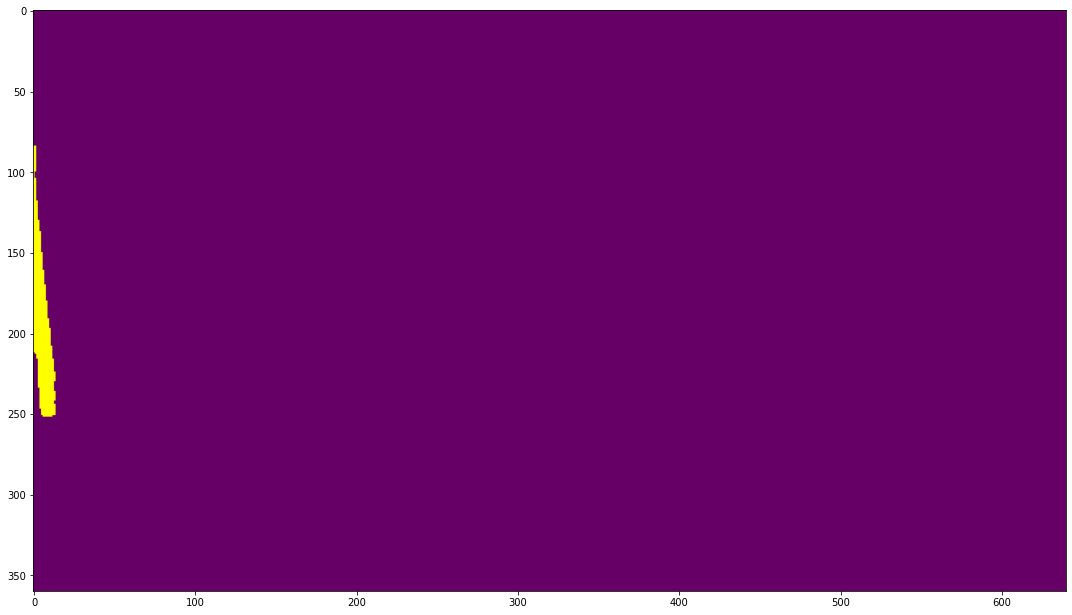

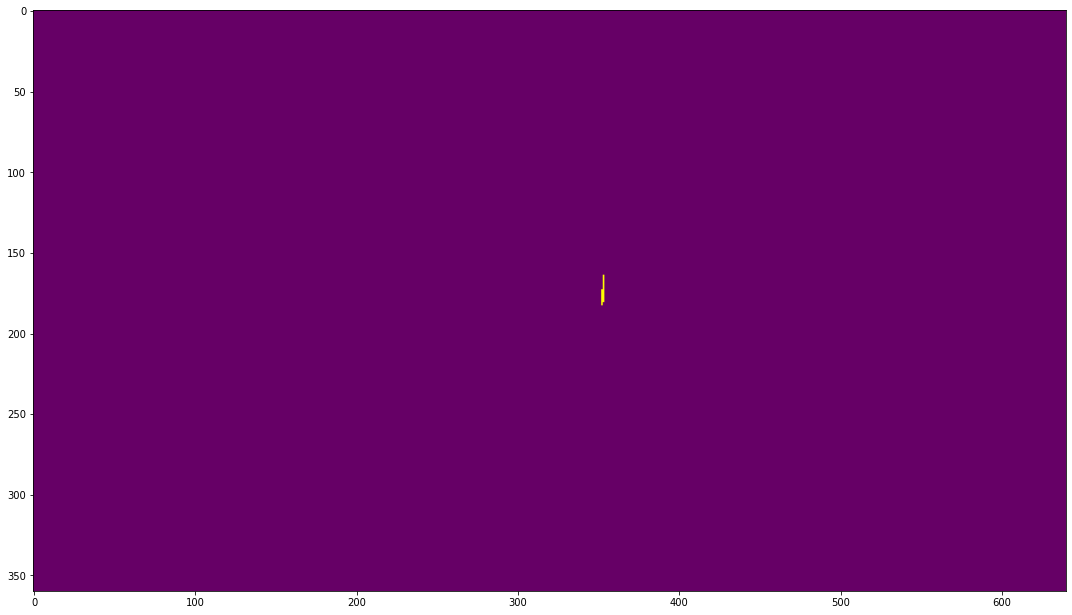

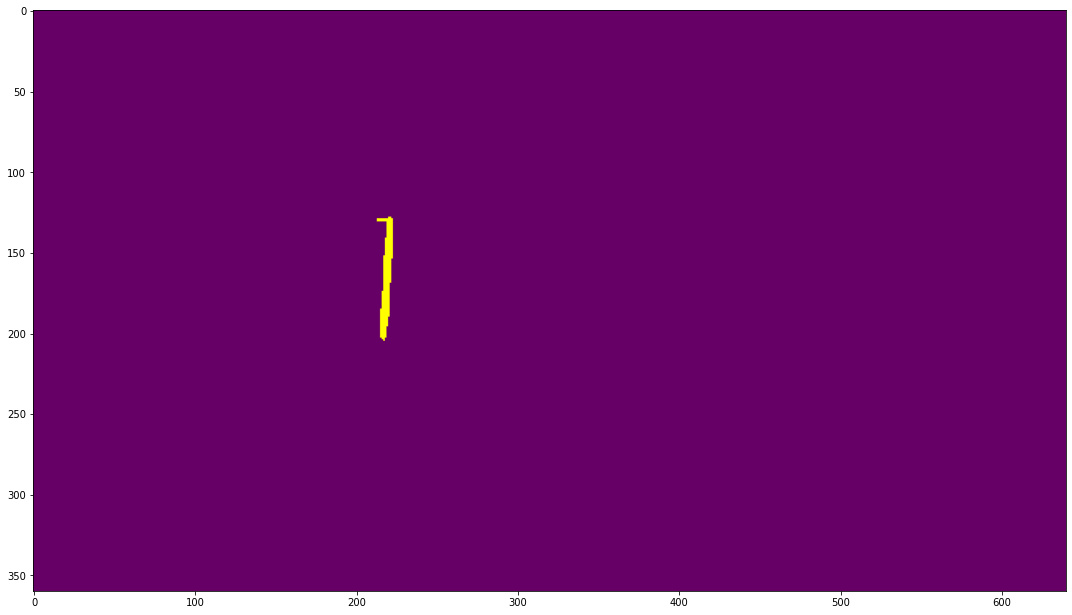

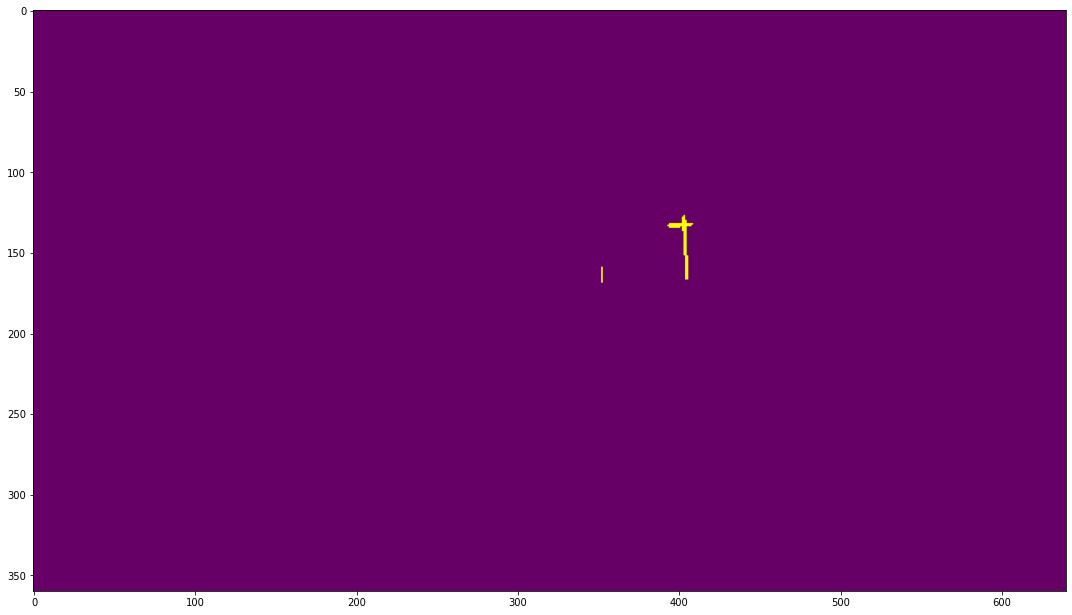

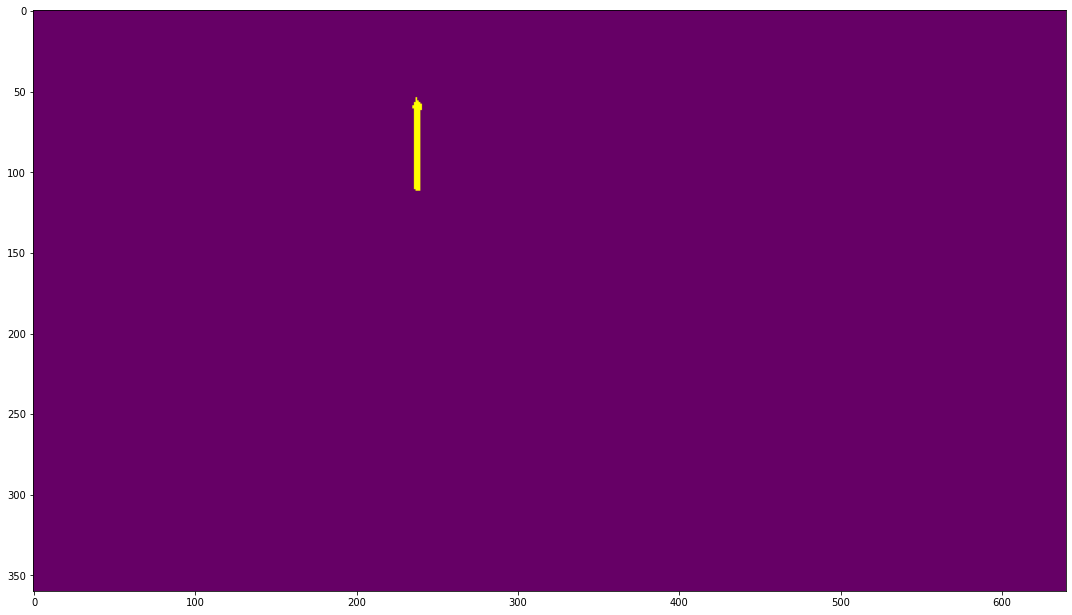

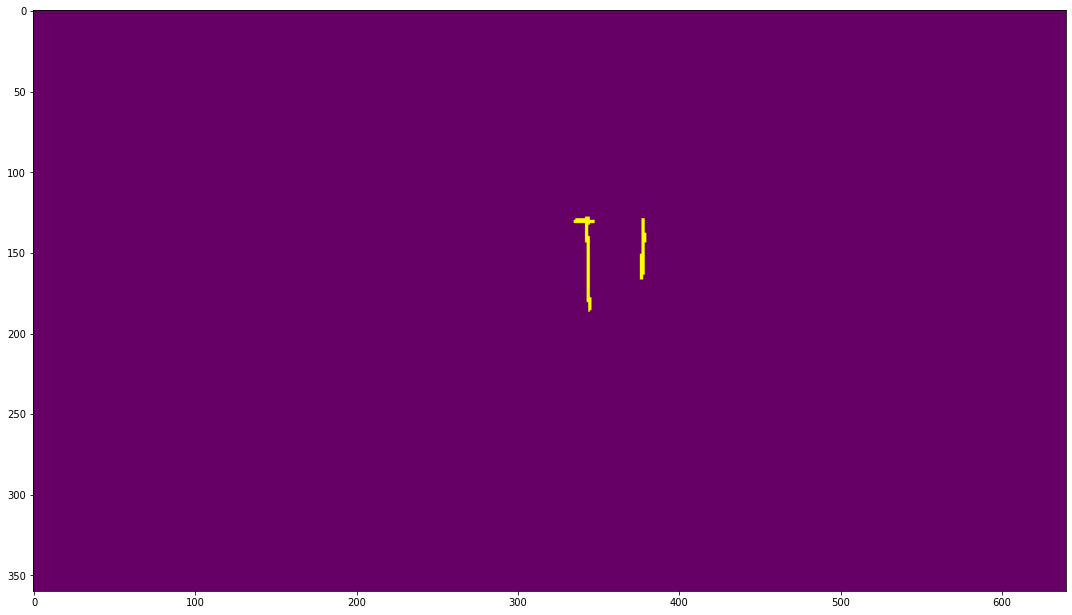

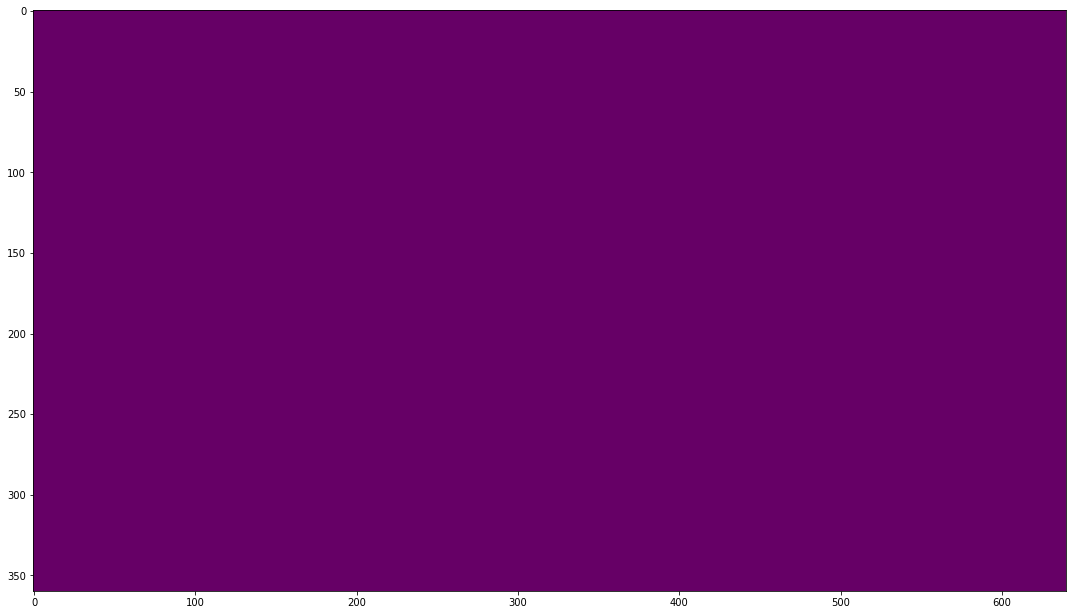

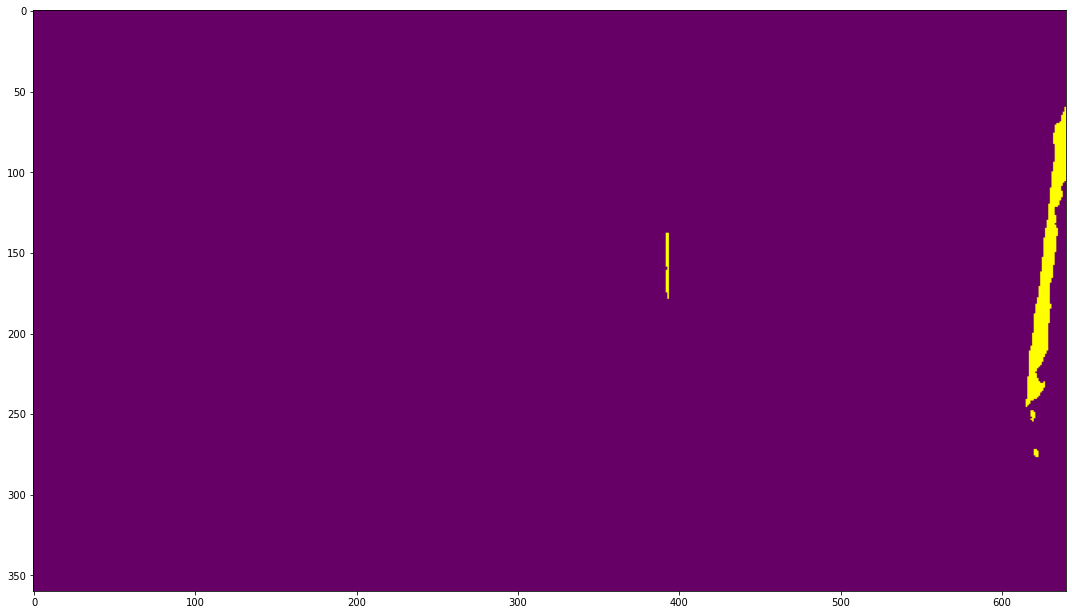

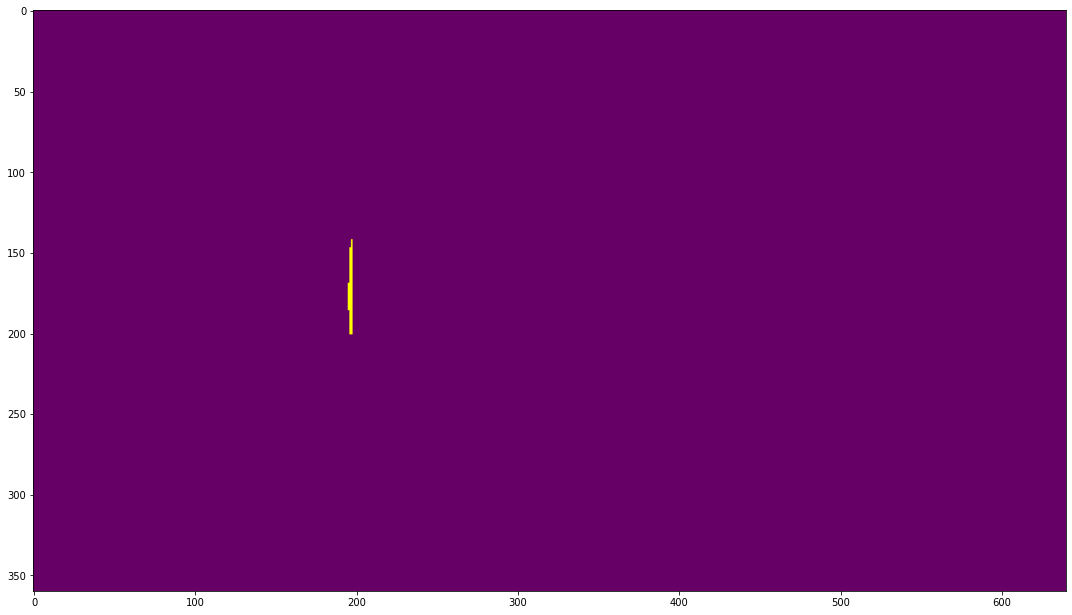

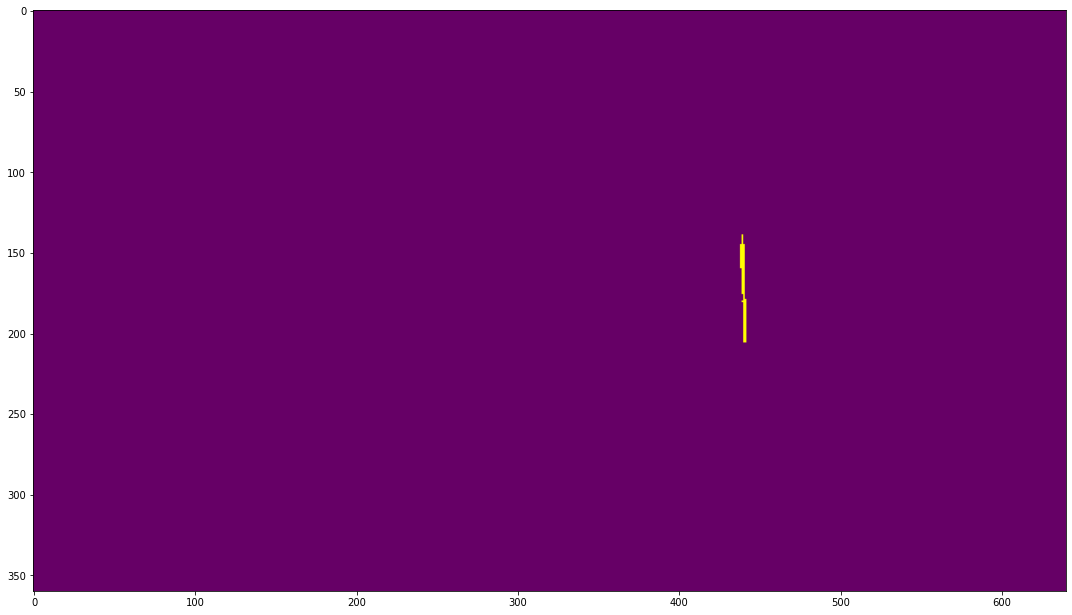

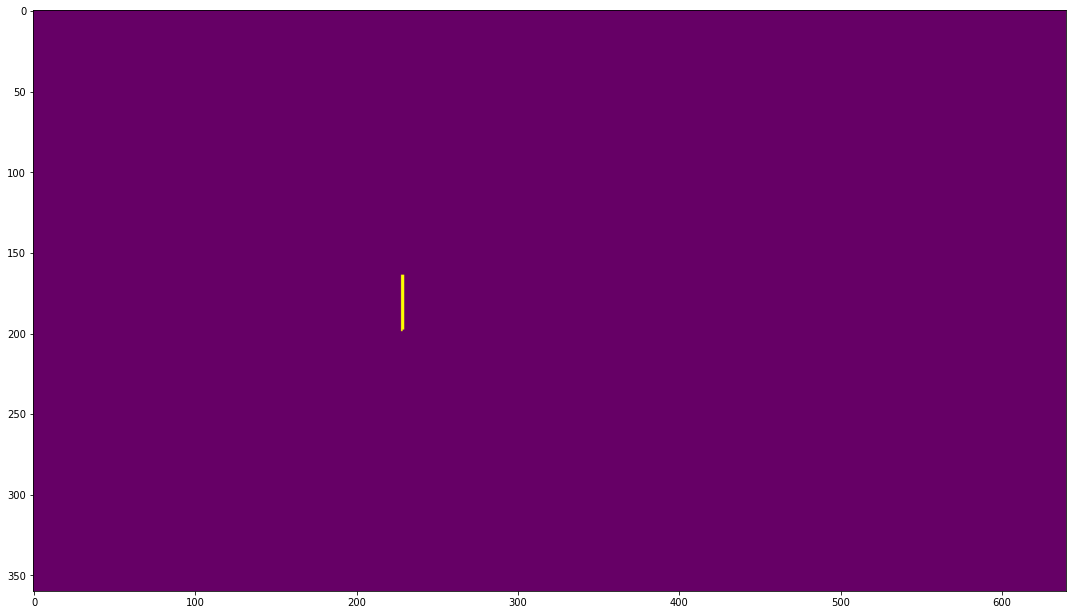

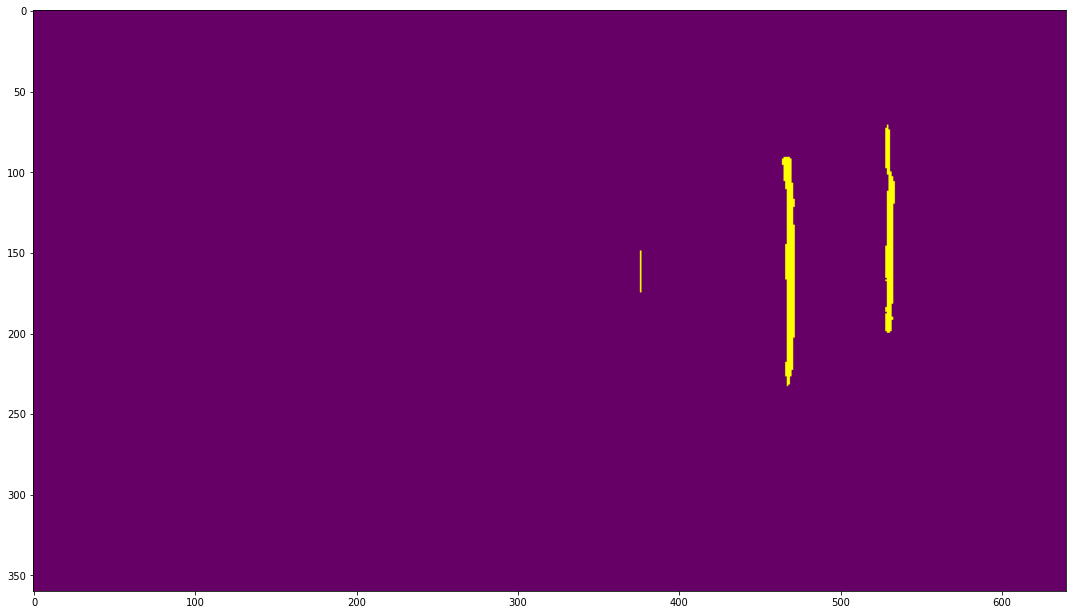

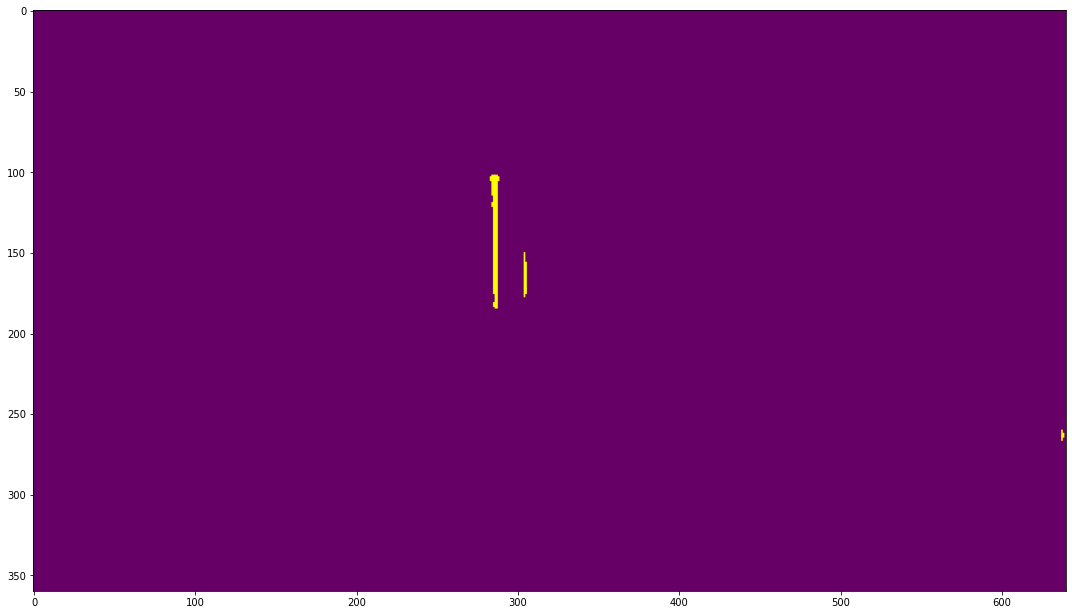

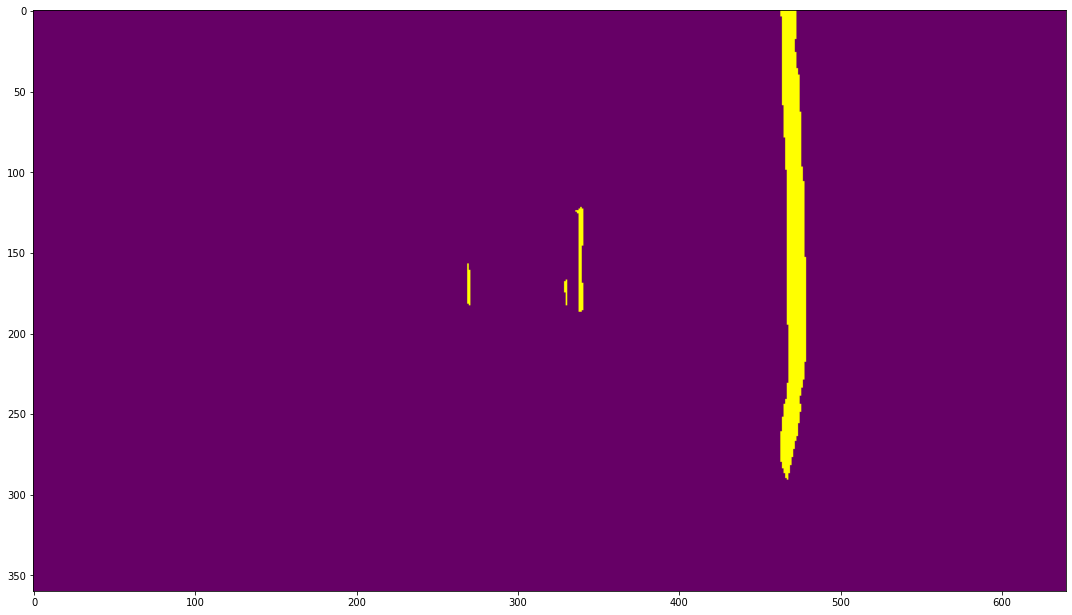

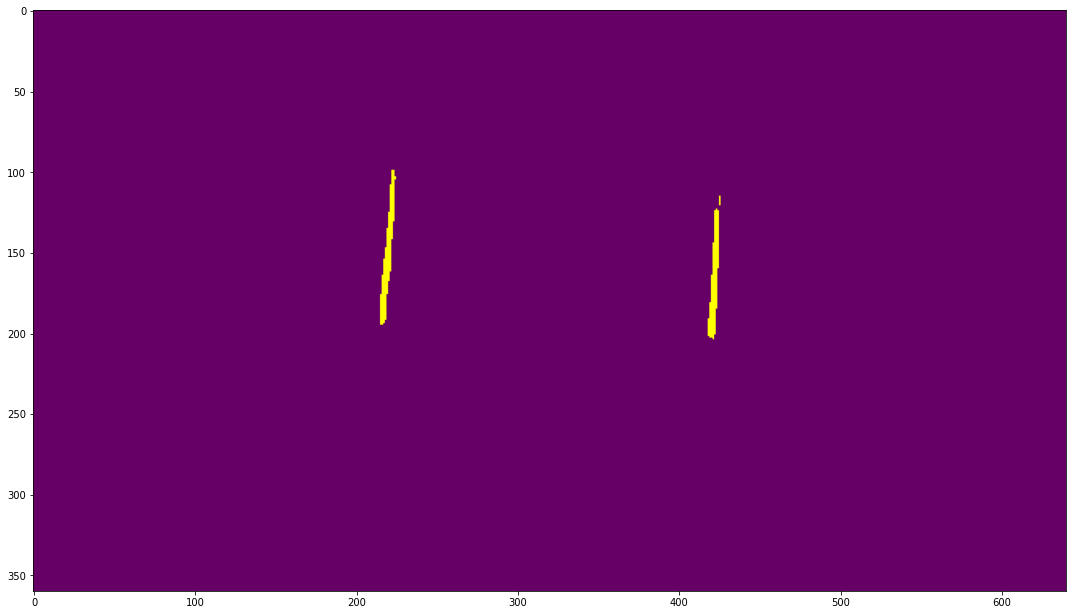

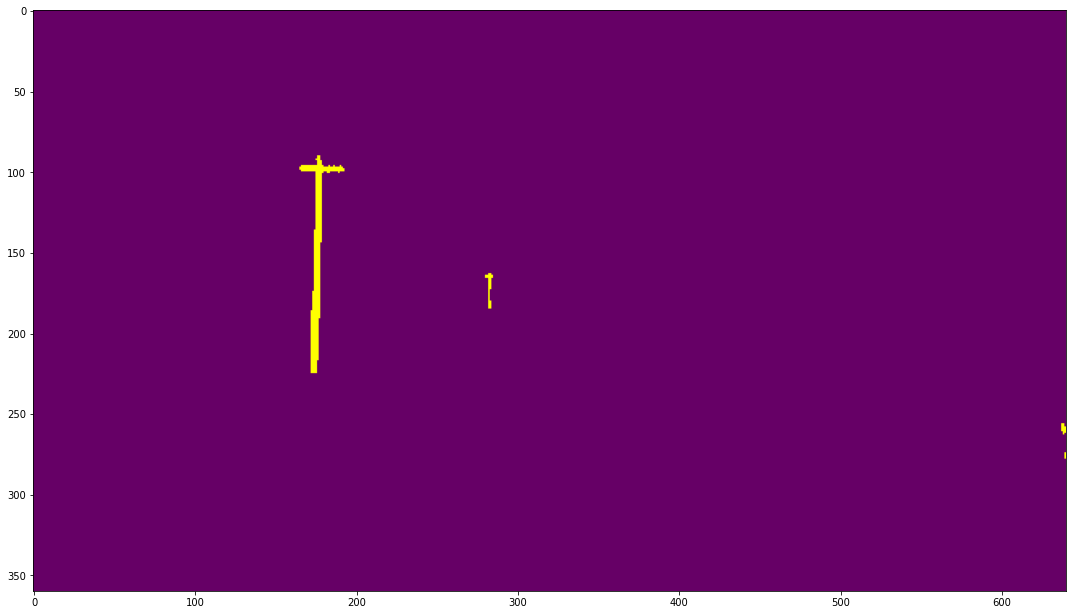

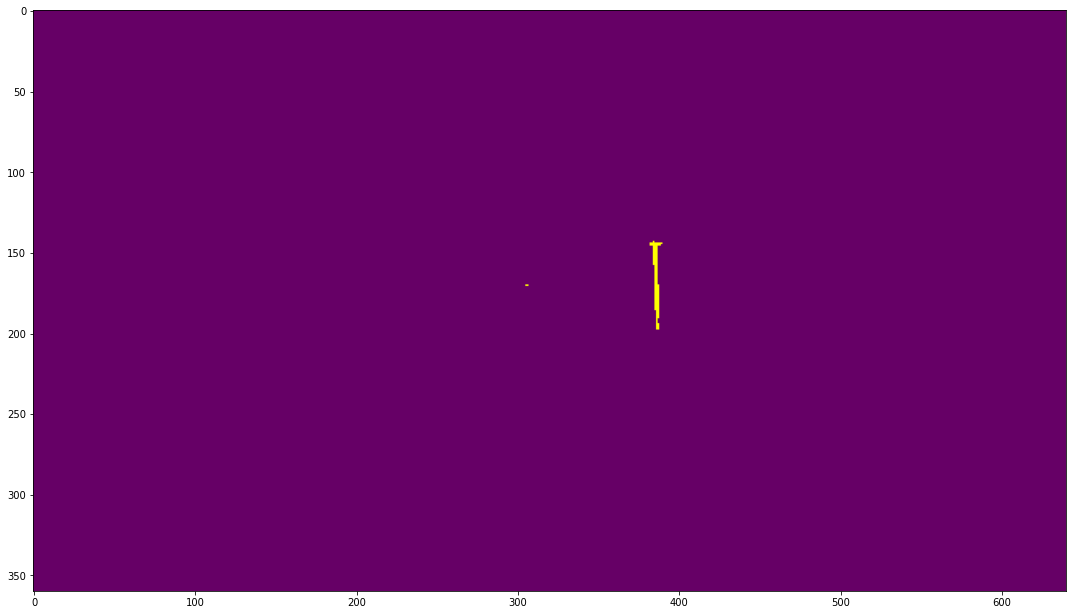

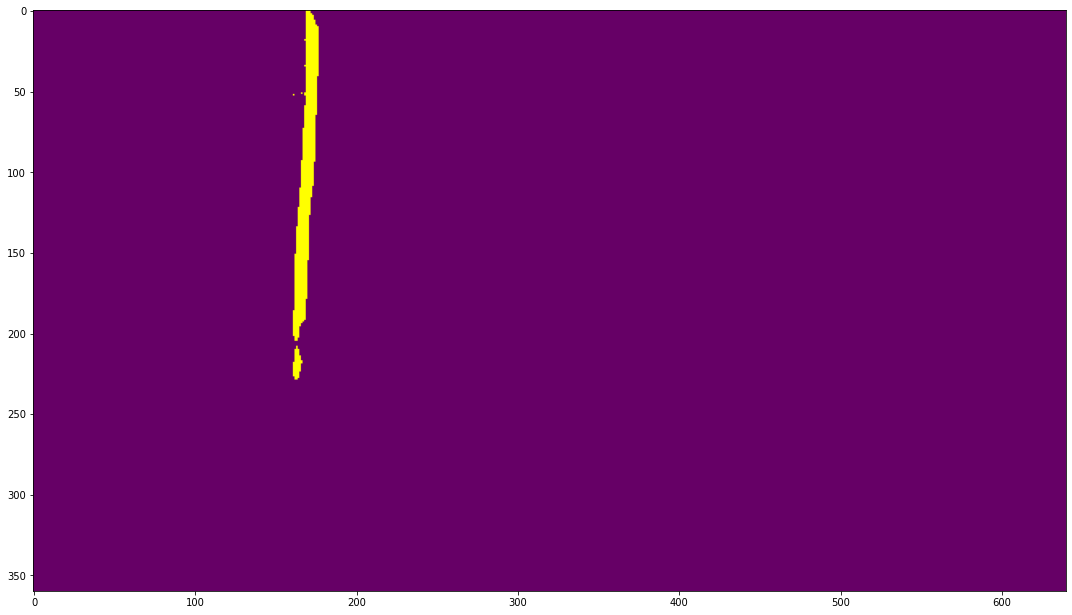

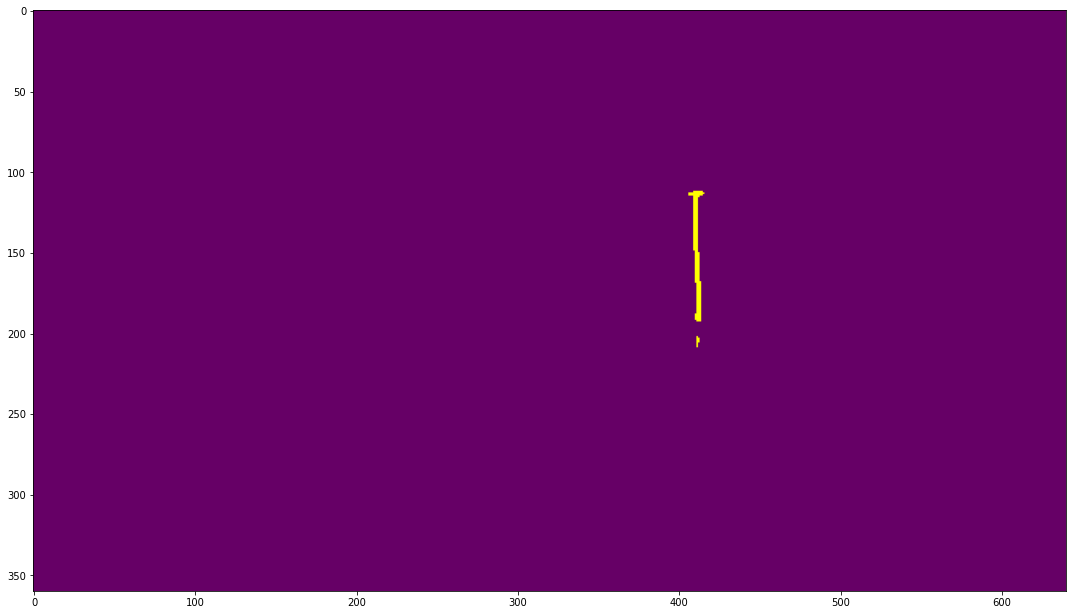

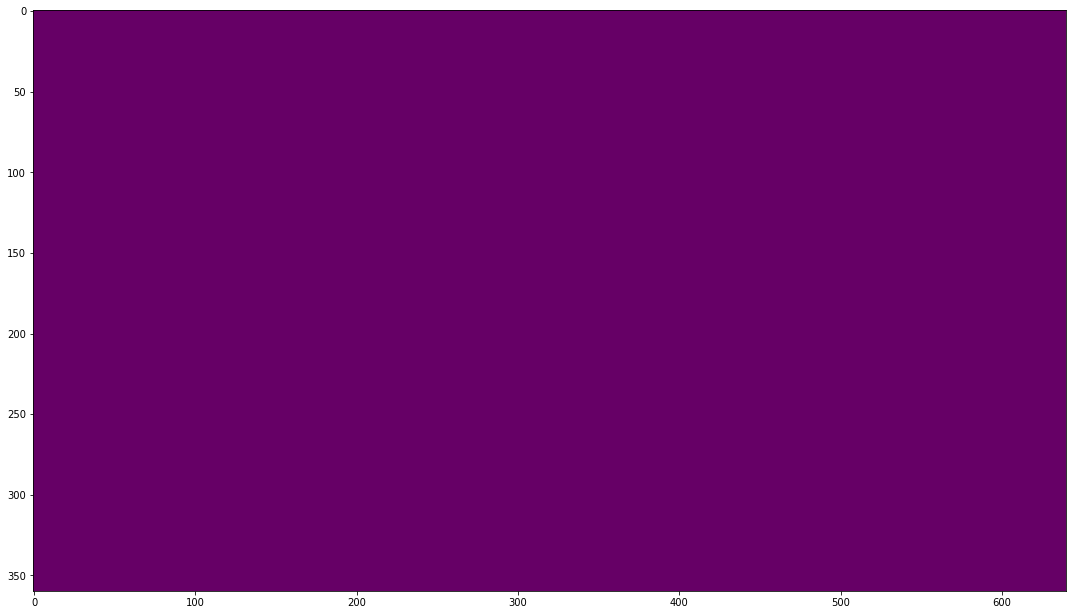

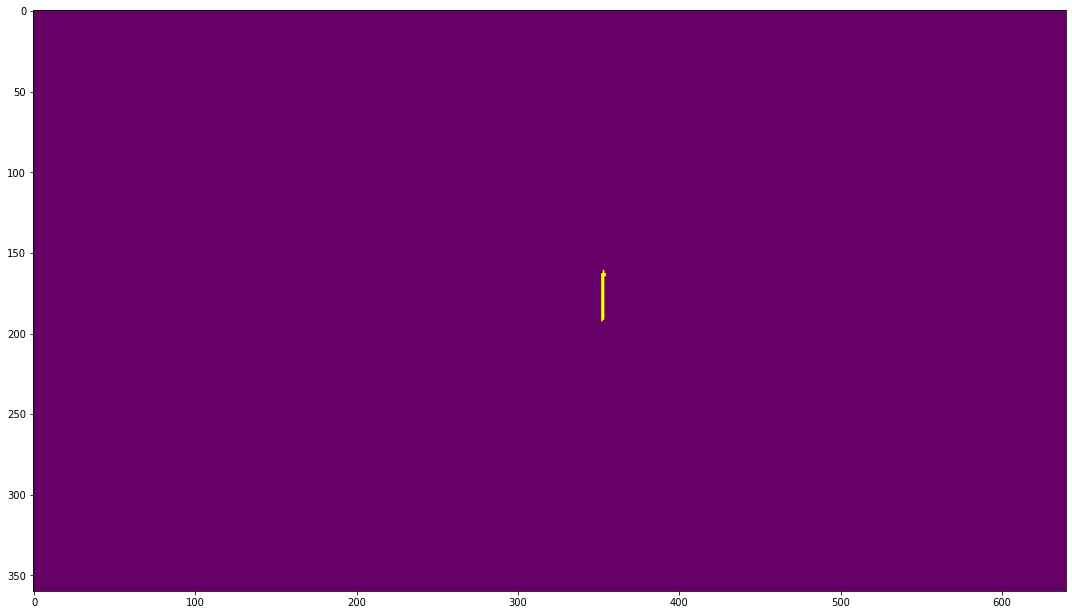

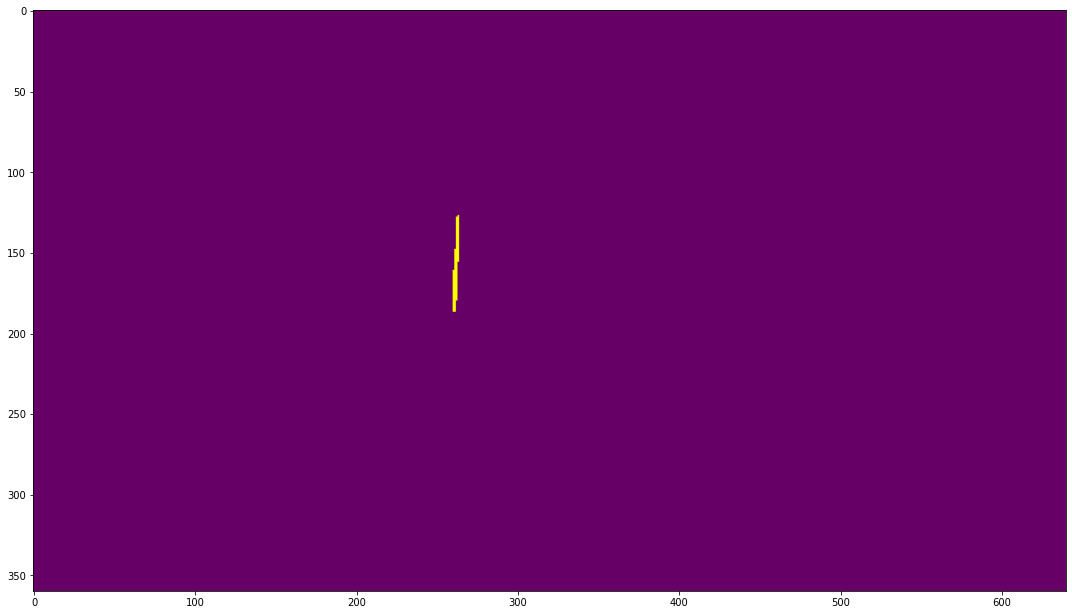

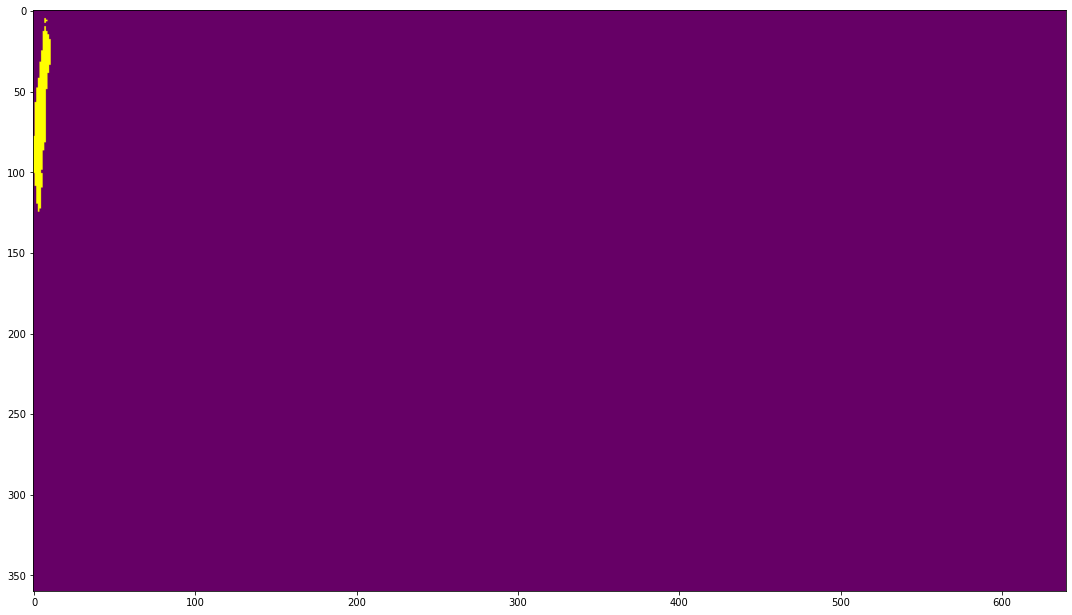

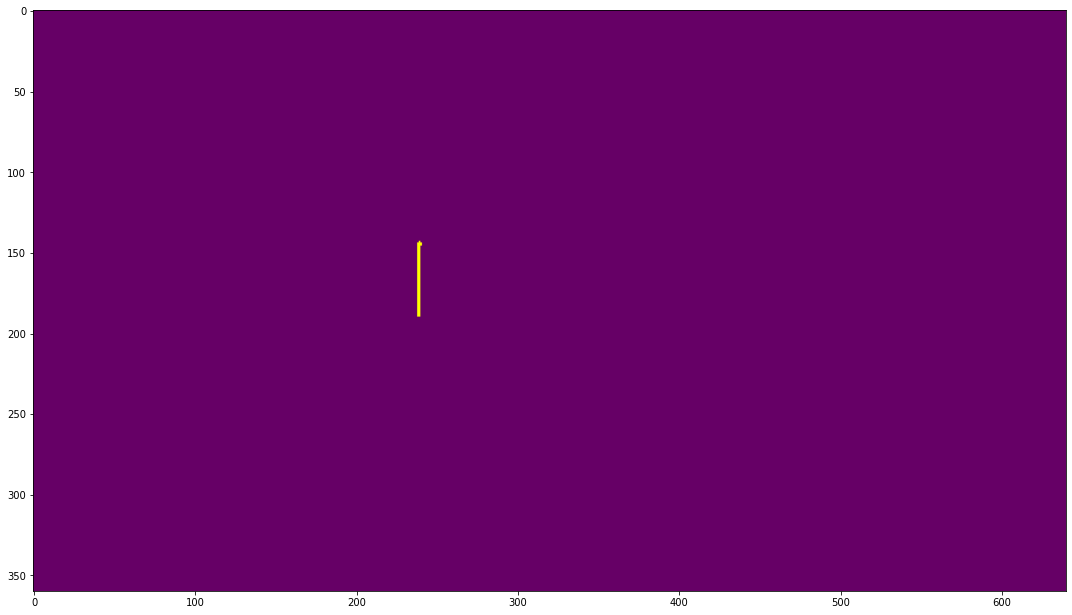

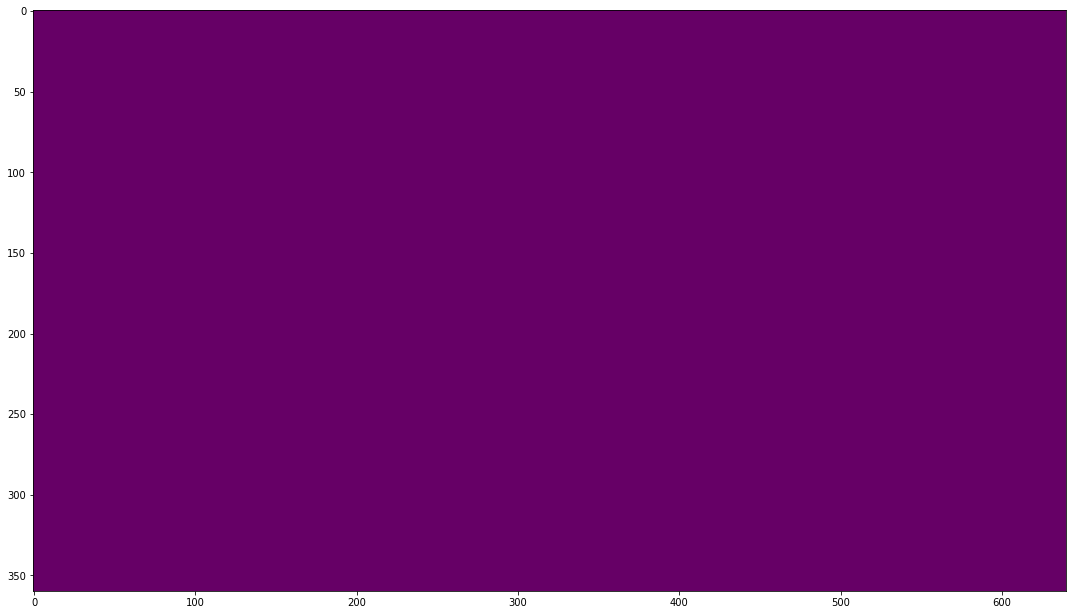

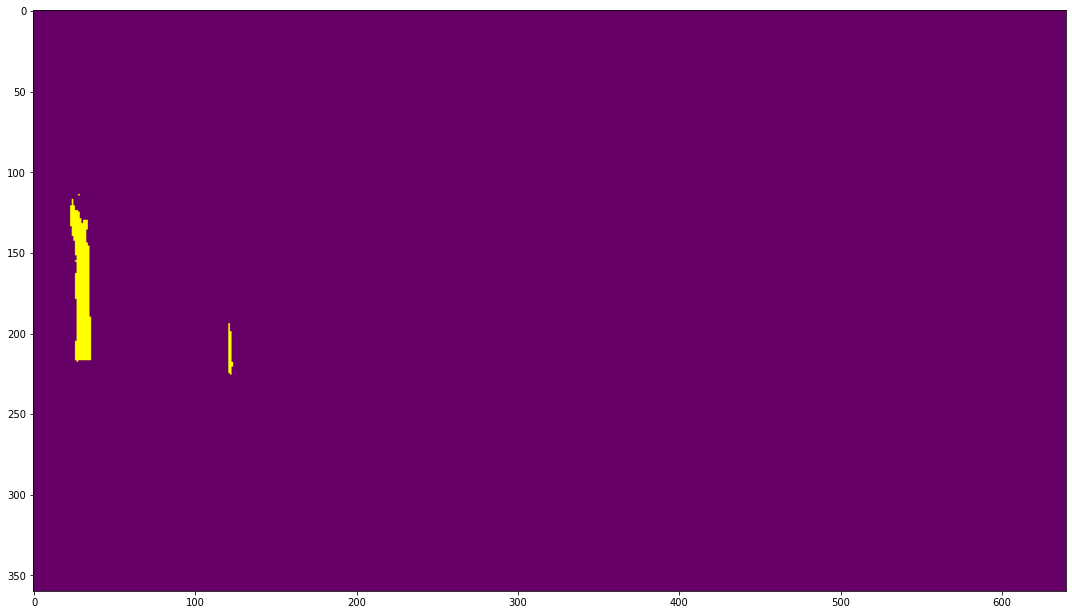

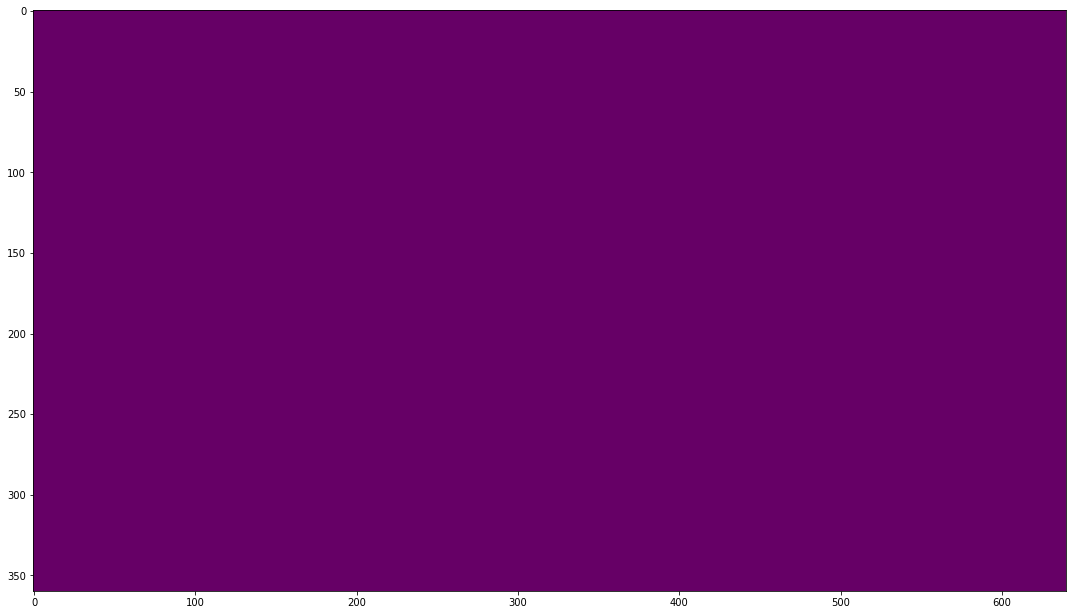

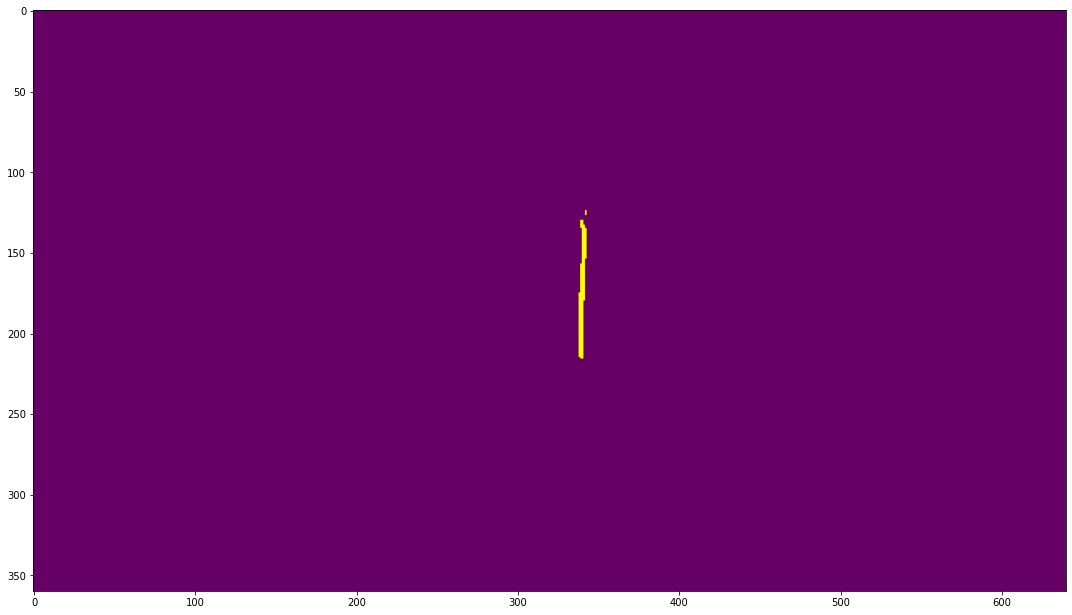

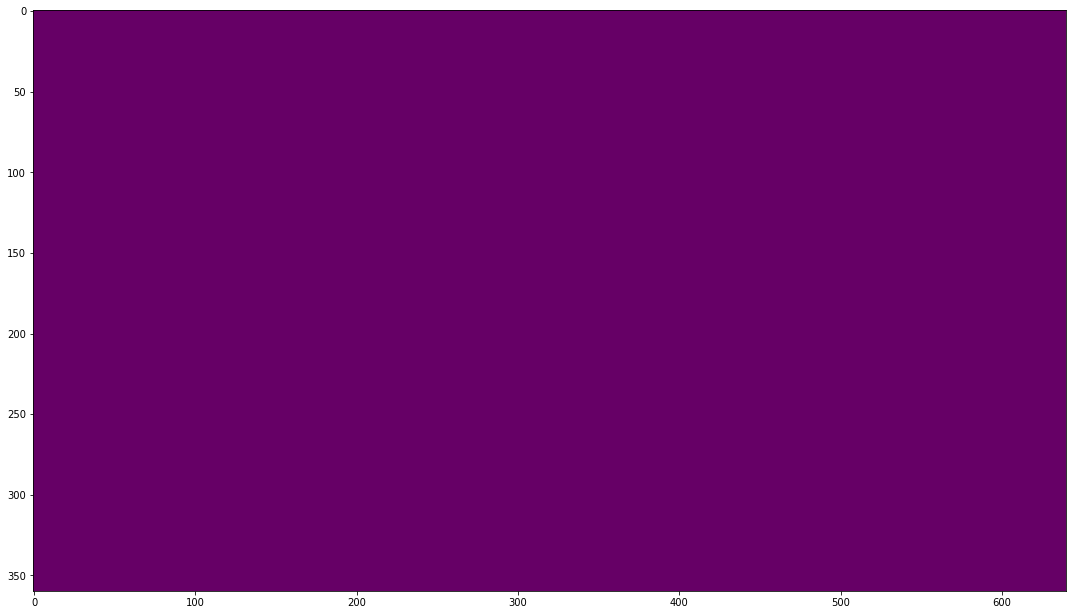

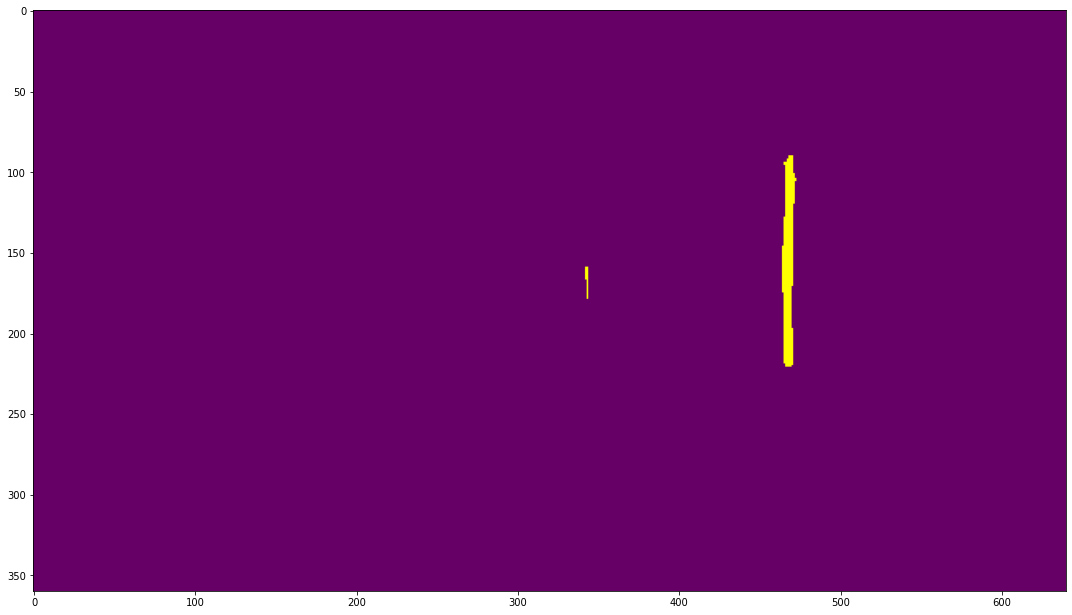

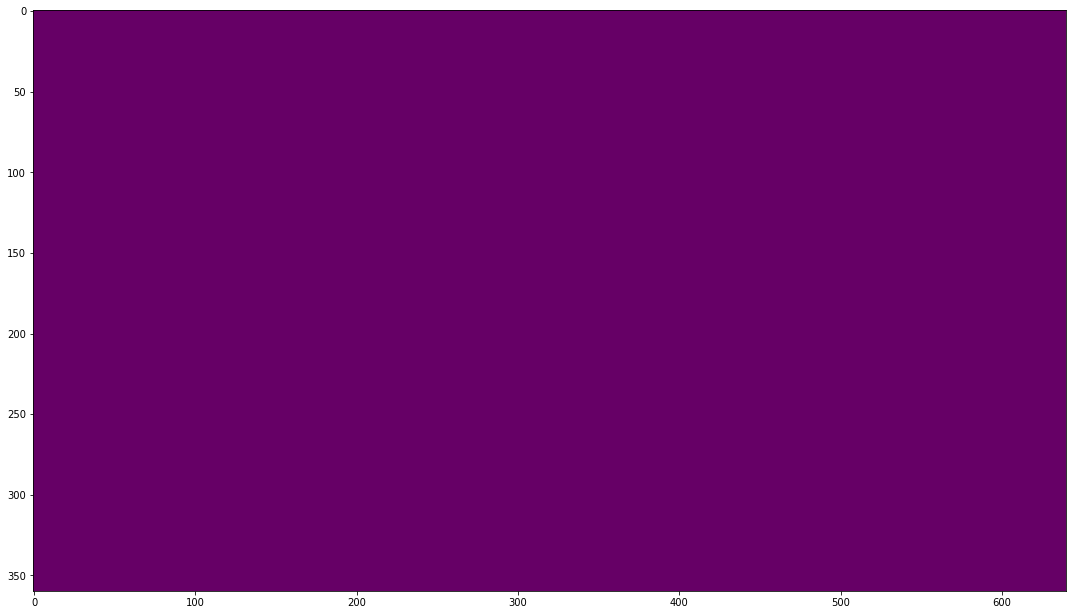

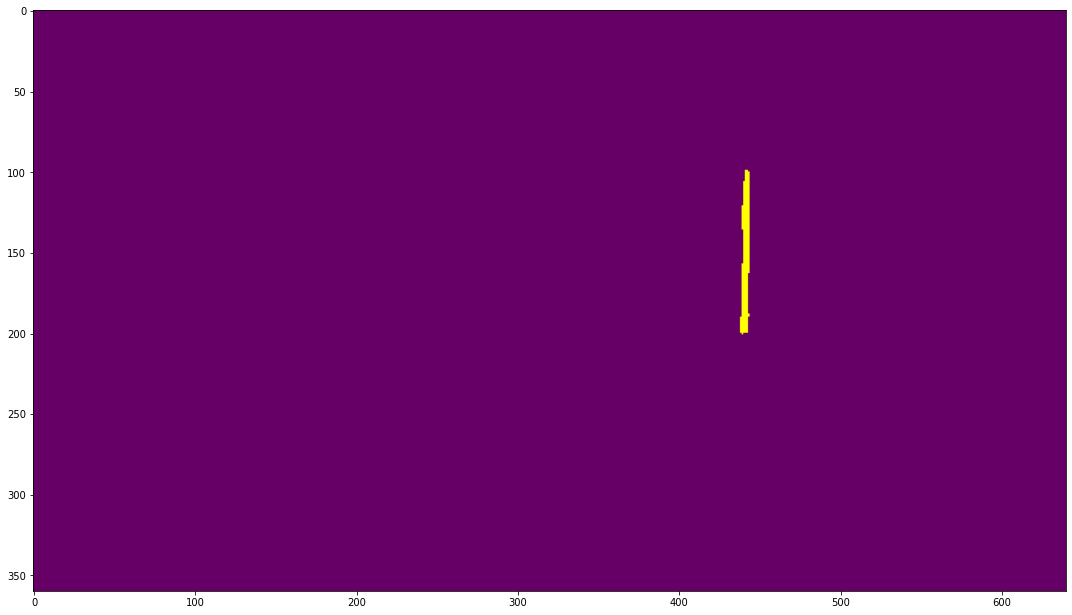

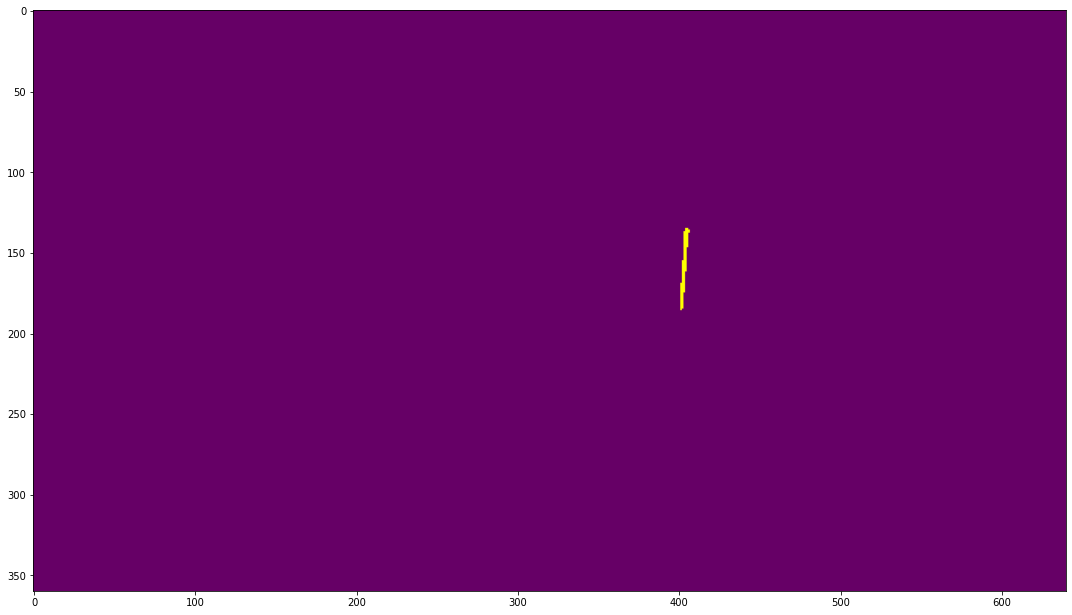

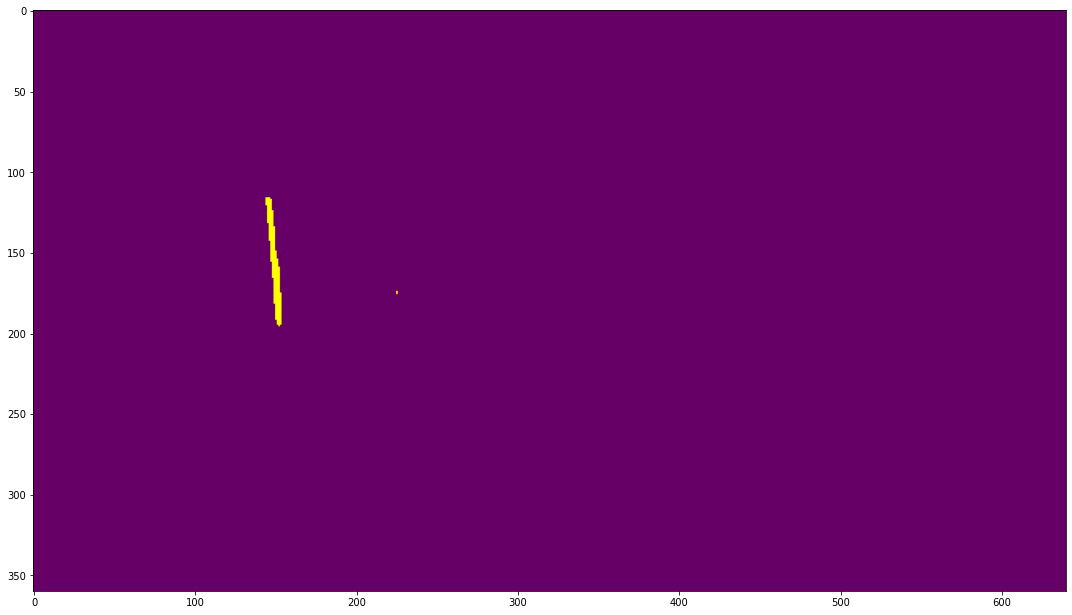

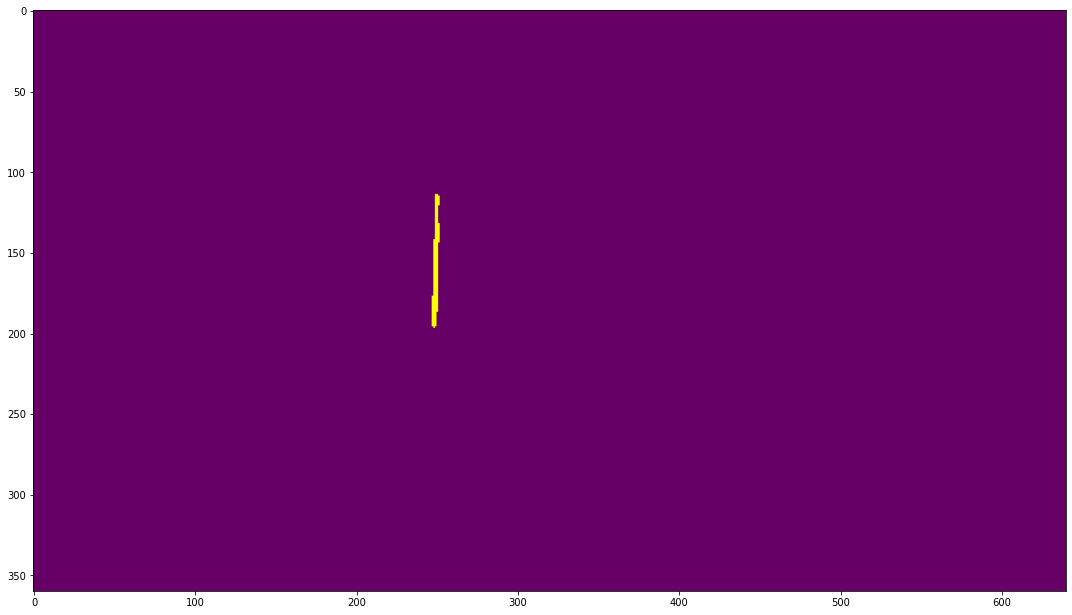

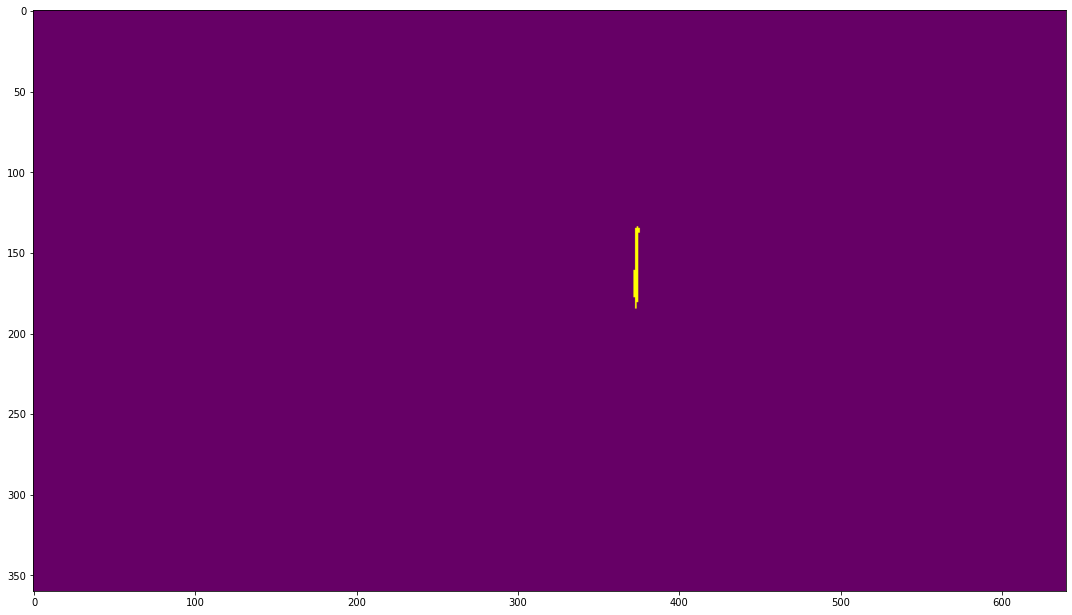

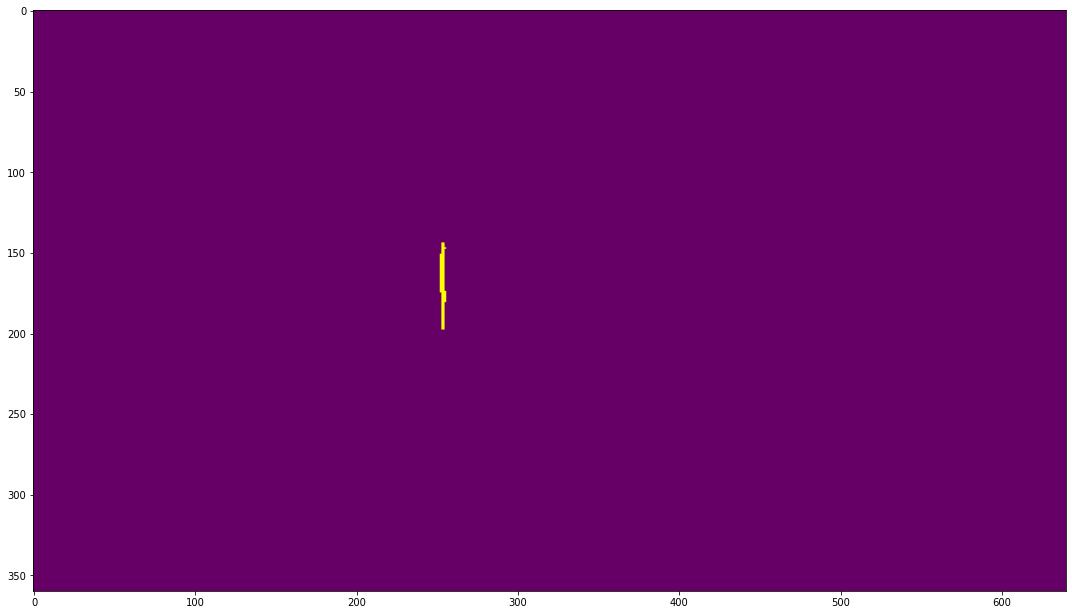

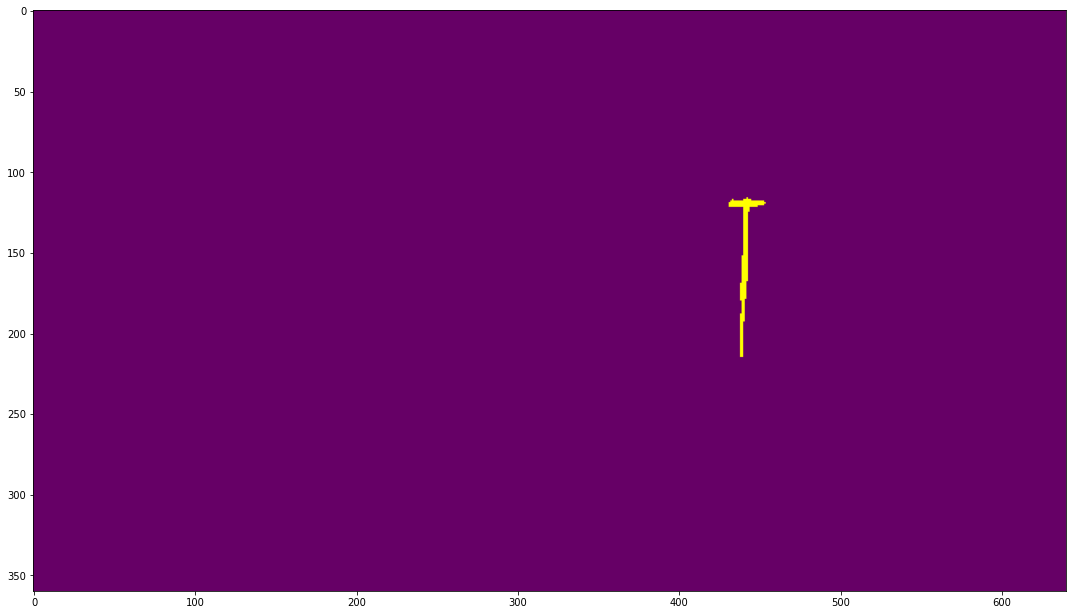

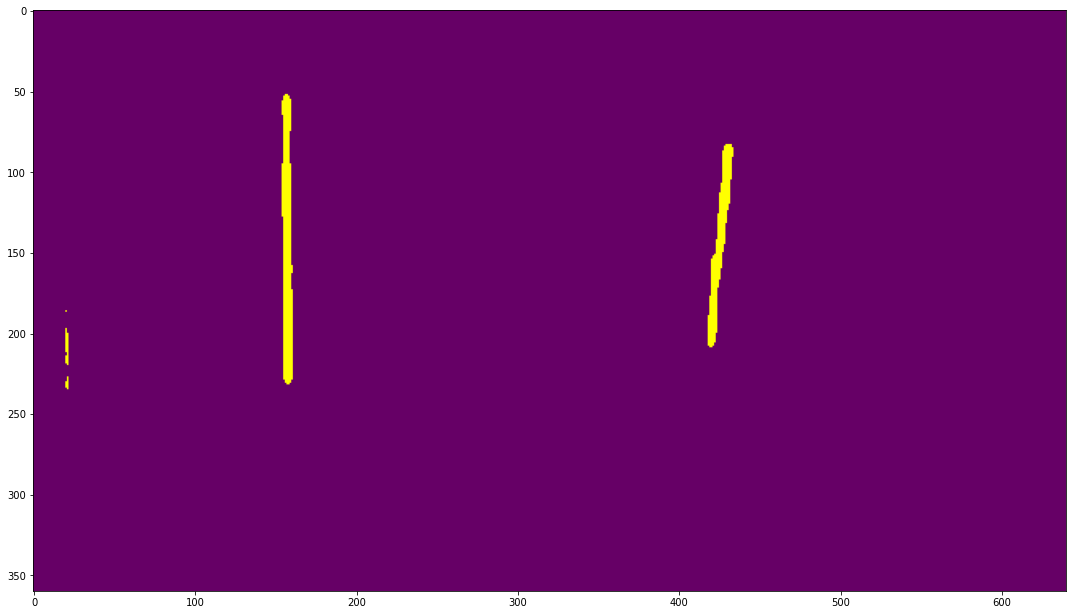

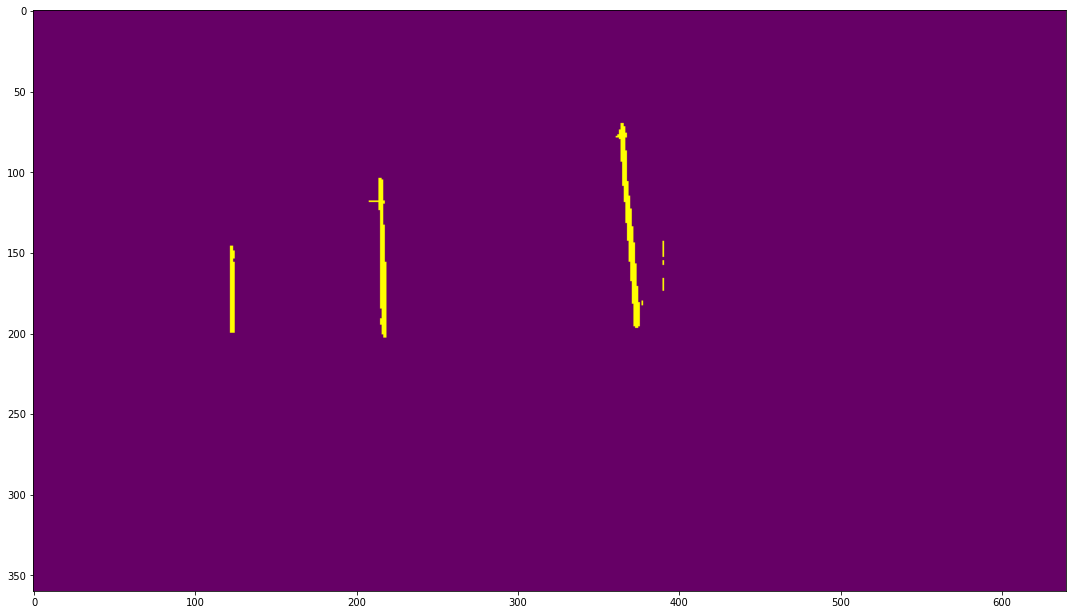

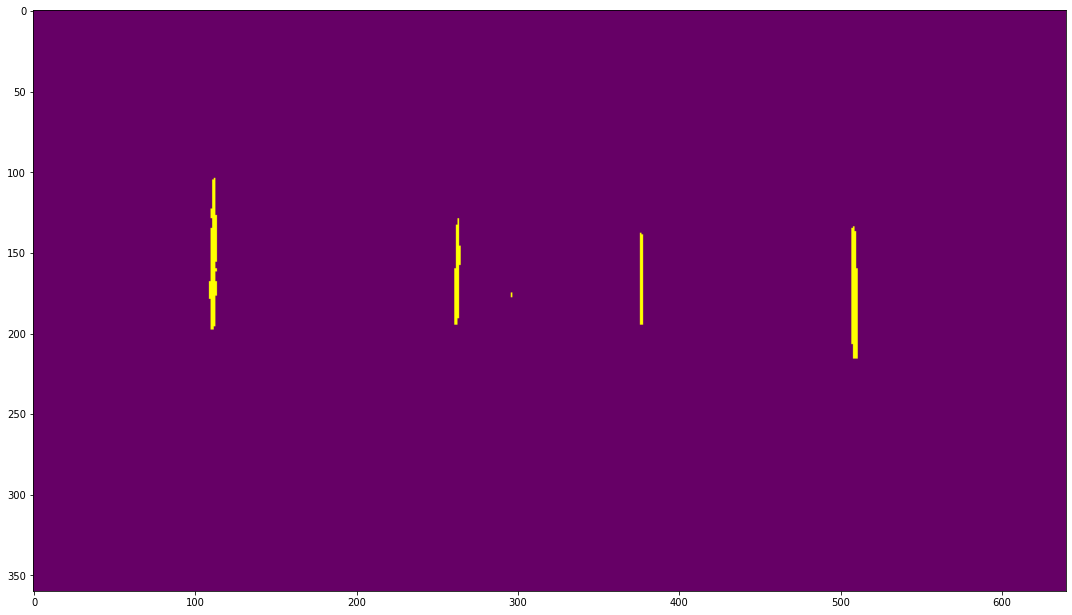

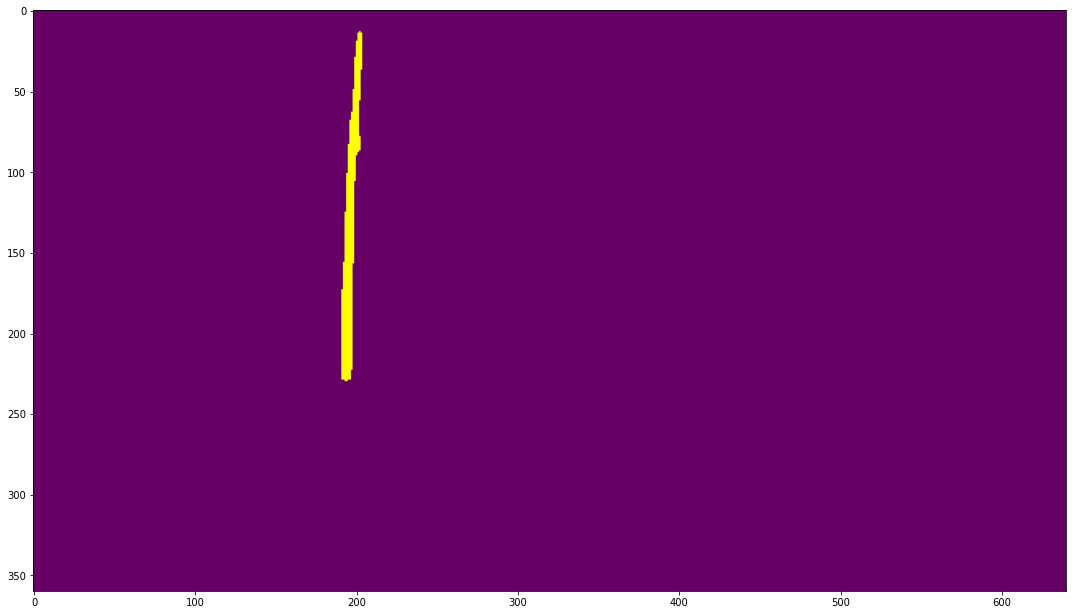

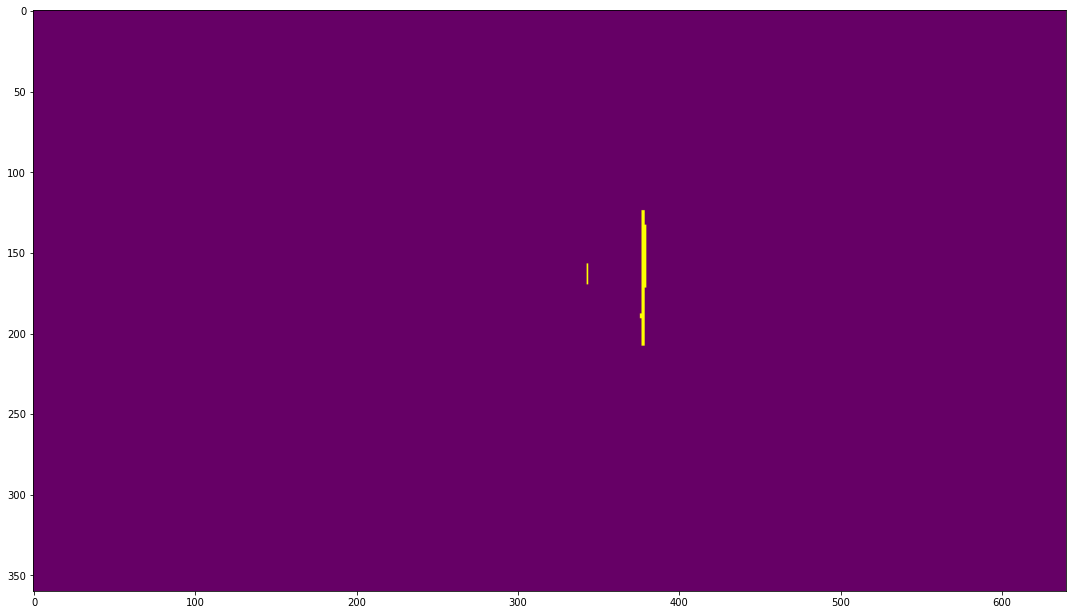

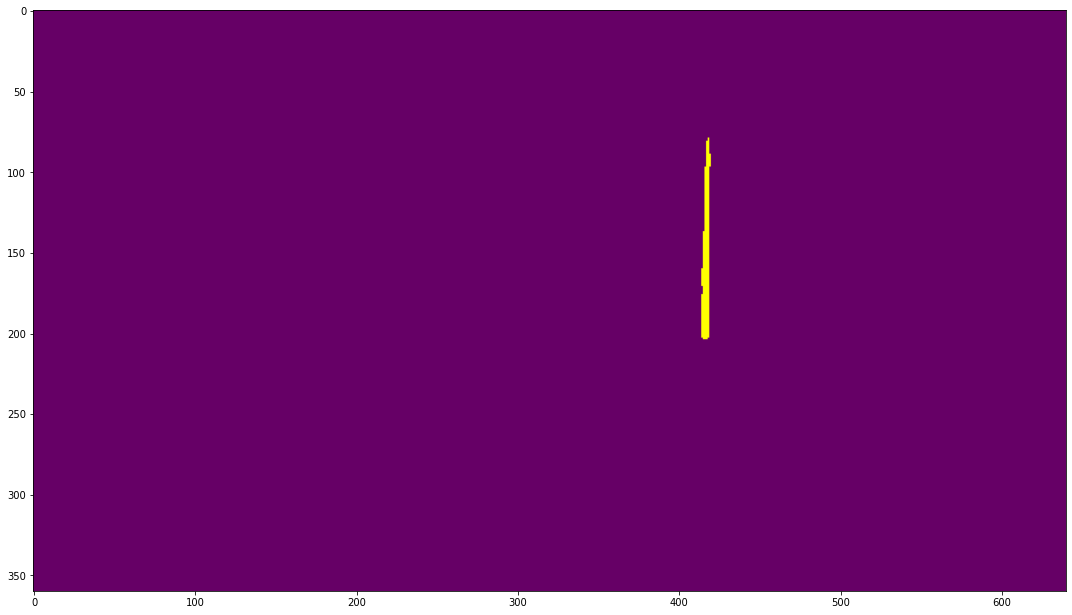

In [61]:
from mmseg.apis import inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
import mmcv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import os
import glob
import zipfile
from PIL import Image
import random

PATH_TO_TEST_IMAGES_DIR= data_root + dataset + "/img_dir" #Test images directory
PATH_TO_LABEL_IMAGES_DIR= data_root + dataset + "/ann_dir" #Test Annotaions Directory
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jpg")) #Test Images in .jpg format
LABEL_PATHS= glob.glob(os.path.join(PATH_TO_LABEL_IMAGES_DIR, "*.png")) #Test Annotations in .png format

TEST_IMAGE_PATHS.sort()
LABEL_PATHS.sort()

print(len(TEST_IMAGE_PATHS))

res_palette = [[102, 0, 102],[255,255,0]]
#res_palette = [[102, 0, 102],[102, 0, 102],[102, 0, 102],[102, 0, 102],[102, 0, 102],[255,255,0],[102, 0, 102],[102, 0, 102],[102, 0, 102],[102, 0, 102],[102, 0, 102],[102, 0, 102],[102, 0, 102],[102, 0, 102],[102, 0, 102],[102, 0, 102],[102, 0, 102],[102, 0, 102],[102, 0, 102]]

for i in range(0,len(TEST_IMAGE_PATHS)):
  img_name= LABEL_PATHS[i].split("/")[7] 

  #predcition over image
  img = TEST_IMAGE_PATHS[i]
  result = inference_segmentor(model, img)

  # show the results and save prediction
  image_filename = "predictions/"+ img_name

  #show_result_pyplot(model, img, result, get_palette('cityscapes'), opacity=1, out_file=image_filename)
  show_result_pyplot(model, img, result, res_palette, opacity=1, out_file=image_filename)
 

## Save predictions

In [ ]:
import shutil

# save predictions
%cp -av "/content/mmsegmentation/predictions/" "/content/drive/MyDrive/NRCan2022/predictions/"

'/content/mmsegmentation/predictions/' -> '/content/drive/MyDrive/NRCan2022/predictions_hrnet_finetuned_poles/waterloo/iqaluit/predictions'
'/content/mmsegmentation/predictions/img_ref_0_stp_1_lat_63.7283098518_lon_-68.4444682218_hdg_413.2539711.png' -> '/content/drive/MyDrive/NRCan2022/predictions_hrnet_finetuned_poles/waterloo/iqaluit/predictions/img_ref_0_stp_1_lat_63.7283098518_lon_-68.4444682218_hdg_413.2539711.png'
'/content/mmsegmentation/predictions/img_ref_0_stp_1_lat_63.7285947824_lon_-68.4505059284_hdg_150.545677185.png' -> '/content/drive/MyDrive/NRCan2022/predictions_hrnet_finetuned_poles/waterloo/iqaluit/predictions/img_ref_0_stp_1_lat_63.7285947824_lon_-68.4505059284_hdg_150.545677185.png'
'/content/mmsegmentation/predictions/img_ref_0_stp_1_lat_63.728650701_lon_-68.4439032769_hdg_65.3816452026.png' -> '/content/drive/MyDrive/NRCan2022/predictions_hrnet_finetuned_poles/waterloo/iqaluit/predictions/img_ref_0_stp_1_lat_63.728650701_lon_-68.4439032769_hdg_65.3816452026.png'

## Evaluation with Test Set

In [1]:
test_ann = "/content/mmsegmentation/data_NRCan2022_hrnet/poles/non_adverse/ann_dir"
TEST_LABEL_PATHS = glob.glob(os.path.join(test_ann, "*.png"))

pred = "/content/mmsegmentation/predictions/"
PRED_LABEL_PATHS = glob.glob(os.path.join(pred, "*.png"))

TEST_LABEL_PATHS.sort()
PRED_LABEL_PATHS.sort()

count = 0

for i in range(0, len(PRED_LABEL_PATHS)):
  image_path = test_ann + "/" + PRED_LABEL_PATHS[i].split("/")[4]
  if os.path.exists(image_path):
    count = count + 1
count

NameError: ignored

In [63]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import os
import glob
import zipfile
from PIL import Image

iou_sum = []
poles_gt = []

for a in range(0, len(PRED_LABEL_PATHS)):
  im1 = Image.open(PRED_LABEL_PATHS[a], "r")
  image_path = test_ann + "/" + PRED_LABEL_PATHS[a].split("/")[4]
  if os.path.exists(image_path):
    im2 = Image.open(image_path, "r")
  width1, height1 = im1.size
  width2, height2 = im2.size
  
  if width1 != width2 and height1 != height2:
    break

  #get pixel values for predictions; prediction pixels are [255,255,0] for poles and [102, 0, 102] for background
  pixel_values1 = np.array(im1.getdata())
  pixel_values1 = pixel_values1.reshape((height1, width1, 3))
  
  #get pixel values for annotations; annotations are binary image with pixel values 255 for poles and 0 for background
  pixel_values2 = np.array(im2.getdata())
  pixel_values2 = pixel_values2.reshape((height2, width2))
  
  #count predicted pole pixels by counting pixles with value [255, 255, 0] #True Positive + False Positive
  poles_pred = np.count_nonzero(pixel_values1 == 255)/2

  #count actual pole pixels in ground truth image annotations with value 255 #True Positive + False Negative
  pole_gt = np.count_nonzero(pixel_values2 == 255)

  #adding all ground truth positive pole pixels from all images
  poles_gt.append(pole_gt)
  
  intersection = 0
  for i in range(0, height1):
    for j in range(0, width1):
      #compare pixels where prediction pixel = [255, 255, 0] & annotation pixel == 255
      if pixel_values1[i, j, 1] == 255 and pixel_values2[i, j] == 255:
        #Calculate pixels for with the predictions were correct #True Positives
        intersection = intersection + 1
  
  #Calculate Union #True Positives + False Positive + False Negative
  union = poles_pred + pole_gt - intersection
  #Calculate Intersection over Union
  iou = intersection/union
  iou_sum.append(iou)

mean_iou = np.mean(iou_sum)

print(len(iou_sum))
print(mean_iou)

print('Average pole pixels per image:', np.mean(poles_gt))
print('Percentage: {}%'.format(round(((np.mean(poles_gt)/(width1*height1))*100),2)))

44
0.37470208428297247
Average pole pixels per image: 922.4545454545455
Percentage: 0.4%
